In [1]:
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
import joblib

import missingno
import pandas_profiling
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
from scipy.stats import zscore

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb

from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [3]:
df_train.isna().sum() # checking for missing values in training dataset

ID                    0
Age                   0
Gender                0
Income                0
Balance               0
Vintage               0
Transaction_Status    0
Product_Holdings      0
Credit_Card           0
Credit_Category       0
Is_Churn              0
dtype: int64

In [4]:
df_test.isna().sum() # checking for missing values in testing dataset

ID                    0
Age                   0
Gender                0
Income                0
Balance               0
Vintage               0
Transaction_Status    0
Product_Holdings      0
Credit_Card           0
Credit_Category       0
dtype: int64

In [5]:
df_train.nunique().sort_values().to_frame("Unique Values")

,Unique Values
Gender,2
Transaction_Status,2
Credit_Card,2
Is_Churn,2
Product_Holdings,3
Credit_Category,3
Income,4
Vintage,6
Age,52
Balance,6643


In [6]:
df_test.nunique().sort_values().to_frame("Unique Values")

,Unique Values
Gender,2
Transaction_Status,2
Credit_Card,2
Product_Holdings,3
Credit_Category,3
Income,4
Vintage,6
Age,52
Balance,2847
ID,2851


In [7]:
df_train

,ID,Age,Gender,Income,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category,Is_Churn
0,84e2fcc9,36,Female,5L - 10L,563266.44,4,0,1,0,Average,1
1,57fea15e,53,Female,Less than 5L,875572.11,2,1,1,1,Poor,0
2,8df34ef3,35,Female,More than 15L,701607.06,2,1,2,0,Poor,0
3,c5c0788b,43,Female,More than 15L,1393922.16,0,1,2,1,Poor,1
4,951d69c4,39,Female,More than 15L,893146.23,1,1,1,1,Good,1
...,...,...,...,...,...,...,...,...,...,...,...
6645,a8216afd,61,Male,5L - 10L,1354526.19,4,1,2,1,Poor,1
6646,153a306b,42,Female,5L - 10L,596286.54,3,1,2,1,Average,0
6647,d4075a95,29,Male,Less than 5L,979298.19,2,0,2,0,Poor,0
6648,5855b142,66,Female,10L - 15L,395233.65,3,0,2,1,Poor,1


In [8]:
# Label Encoder

le = LabelEncoder()
df_train["Gender"] = le.fit_transform(df_train["Gender"])
df_train.head()

,ID,Age,Gender,Income,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category,Is_Churn
0,84e2fcc9,36,0,5L - 10L,563266.44,4,0,1,0,Average,1
1,57fea15e,53,0,Less than 5L,875572.11,2,1,1,1,Poor,0
2,8df34ef3,35,0,More than 15L,701607.06,2,1,2,0,Poor,0
3,c5c0788b,43,0,More than 15L,1393922.16,0,1,2,1,Poor,1
4,951d69c4,39,0,More than 15L,893146.23,1,1,1,1,Good,1


In [9]:
# Ordinal Encoder

oe = OrdinalEncoder()
oe_col = ["Income", "Product_Holdings", "Credit_Category"]

def ordinal_encode(df, column):
    df[column] = oe.fit_transform(df[column])
    return df

df=ordinal_encode(df_train, oe_col)
df.drop("ID", axis=1 , inplace=True)
df.head()

,Age,Gender,Income,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category,Is_Churn
0,36,0,1.0,563266.44,4,0,0.0,0,0.0,1
1,53,0,2.0,875572.11,2,1,0.0,1,2.0,0
2,35,0,3.0,701607.06,2,1,1.0,0,2.0,0
3,43,0,3.0,1393922.16,0,1,1.0,1,2.0,1
4,39,0,3.0,893146.23,1,1,0.0,1,1.0,1


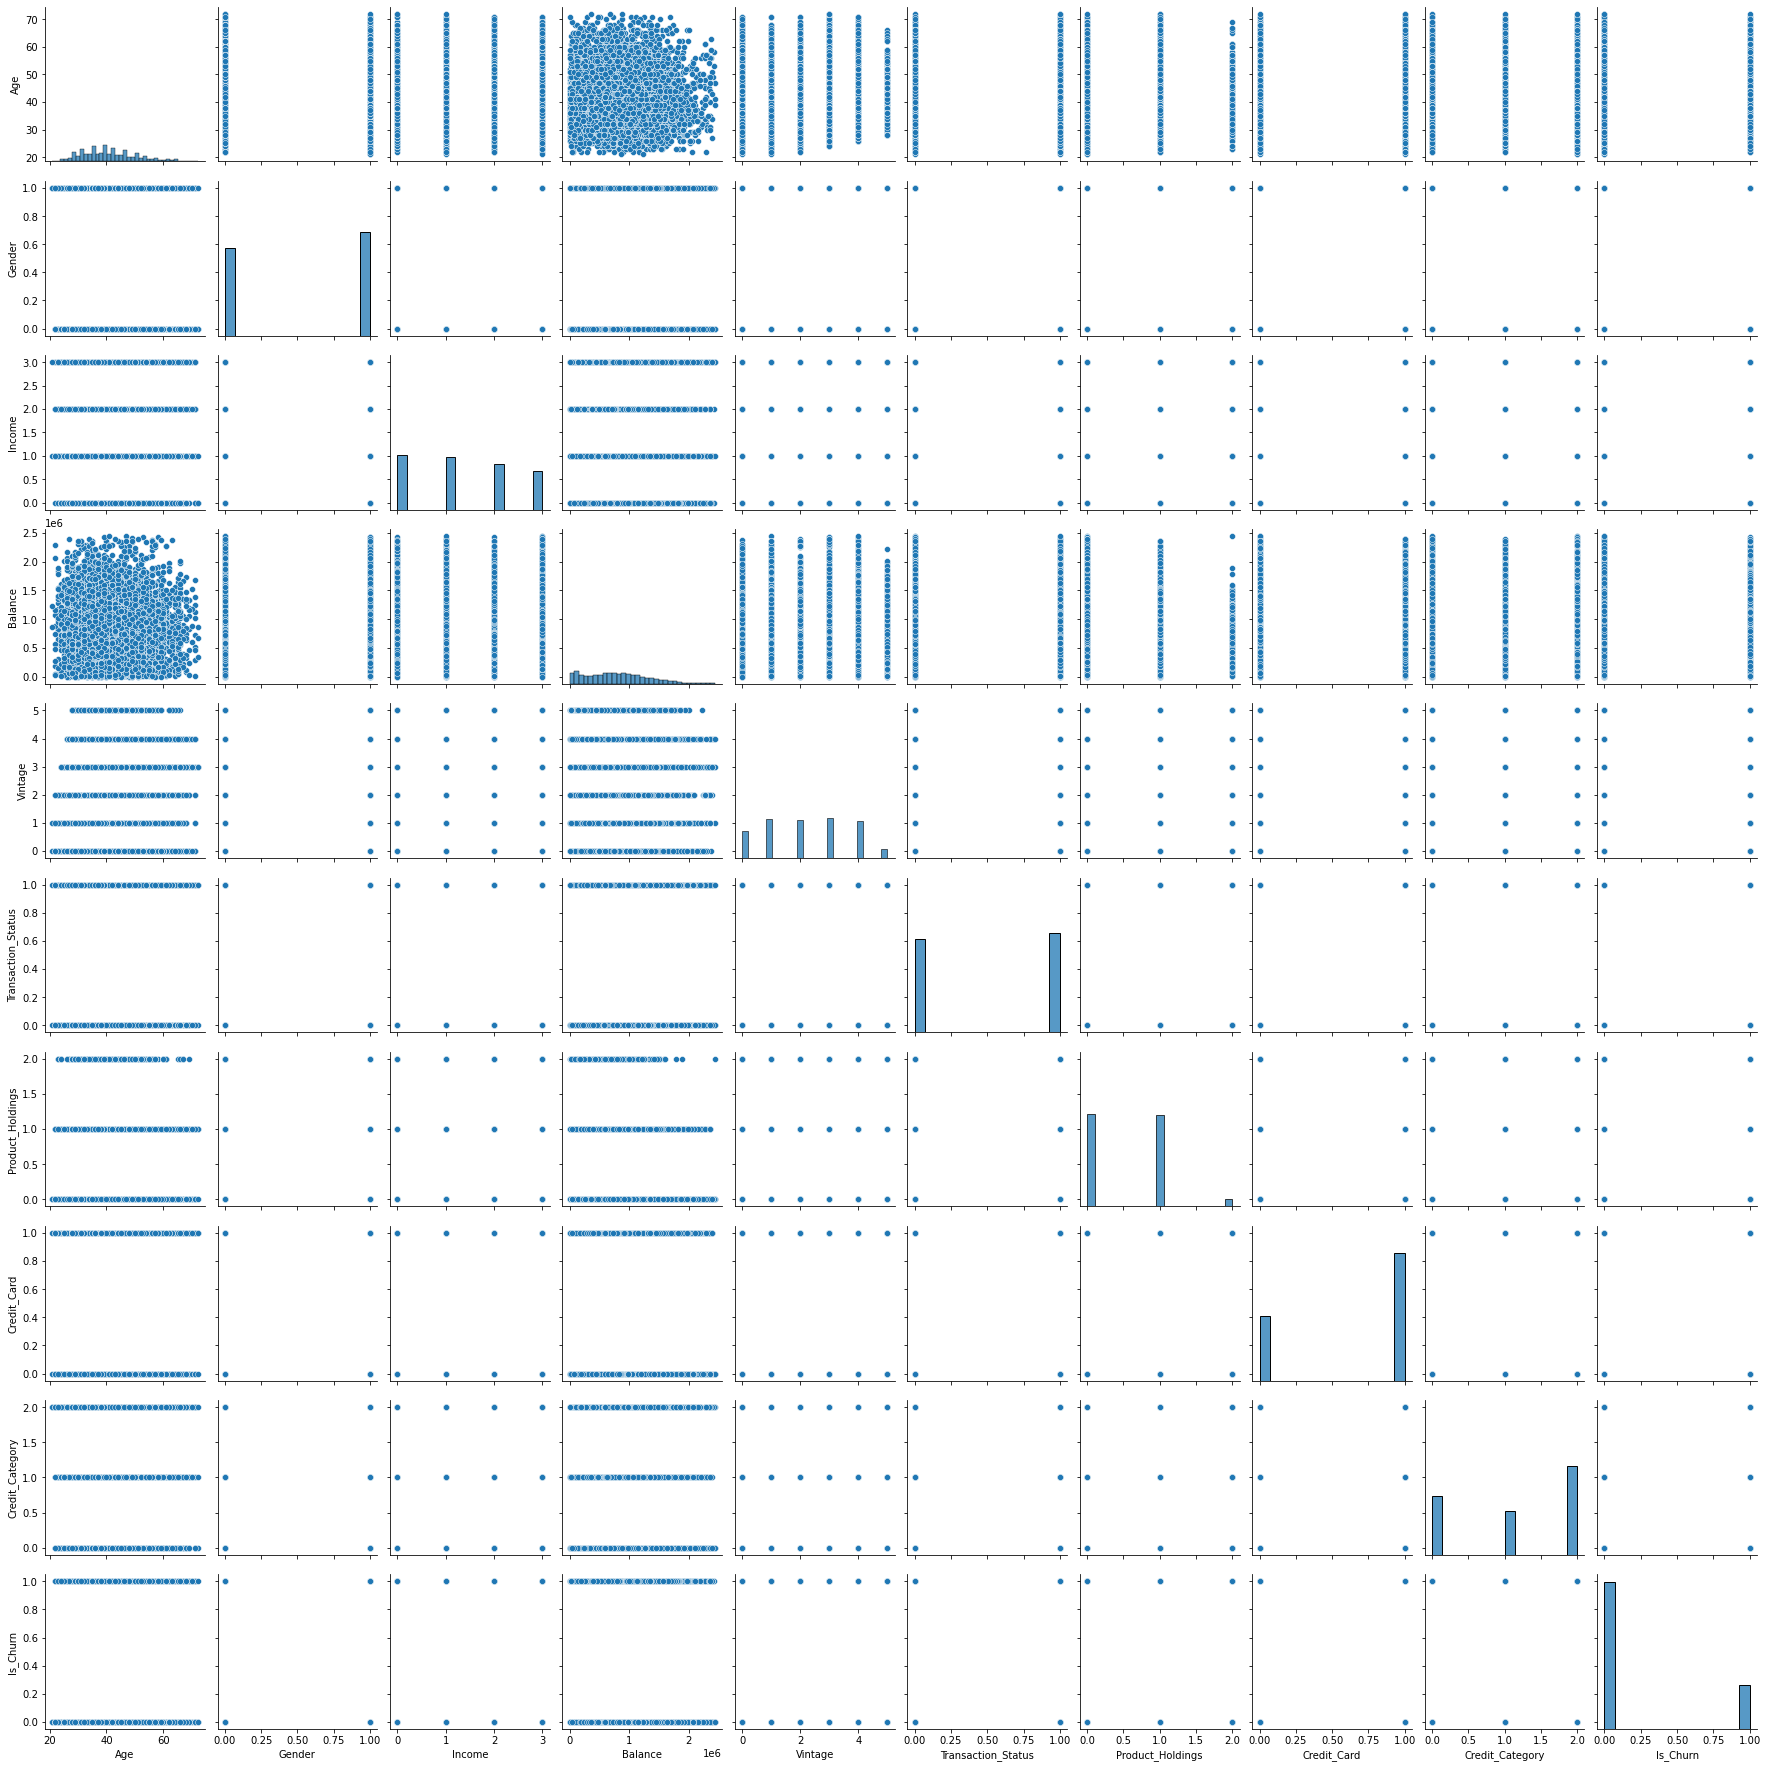

In [10]:
sns.pairplot(df_train)

In [11]:
# Z score method

z=np.abs(zscore(df_train))
threshold=3
np.where(z>3)

df=df_train[(z<3).all(axis=1)]
df

,Age,Gender,Income,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category,Is_Churn
0,36,0,1.0,563266.44,4,0,0.0,0,0.0,1
1,53,0,2.0,875572.11,2,1,0.0,1,2.0,0
2,35,0,3.0,701607.06,2,1,1.0,0,2.0,0
3,43,0,3.0,1393922.16,0,1,1.0,1,2.0,1
4,39,0,3.0,893146.23,1,1,0.0,1,1.0,1
...,...,...,...,...,...,...,...,...,...,...
6645,61,1,1.0,1354526.19,4,1,1.0,1,2.0,1
6646,42,0,1.0,596286.54,3,1,1.0,1,0.0,0
6647,29,1,2.0,979298.19,2,0,1.0,0,2.0,0
6648,66,0,0.0,395233.65,3,0,1.0,1,2.0,1


In [12]:
print("Rows and Columns before using Z Score", df_train.shape)
print("Rows and Columns after using Z Score", df.shape)

Rows and Columns before using Z Score (6650, 10)
Rows and Columns after using Z Score (6615, 10)


In [13]:
# Percentage of Data Loss

data_loss=((df_train.shape[0]-df.shape[0])/df_train.shape[0])*100
print("Total percent of data lost after Z Score to deal with outliers is", data_loss)

Total percent of data lost after Z Score to deal with outliers is 0.5263157894736842


In [14]:
df.skew()

Age                   0.530750
Gender               -0.171489
Income                0.179678
Balance               0.417913
Vintage               0.024153
Transaction_Status   -0.062024
Product_Holdings      0.410709
Credit_Card          -0.700062
Credit_Category      -0.308035
Is_Churn              1.283918
dtype: float64

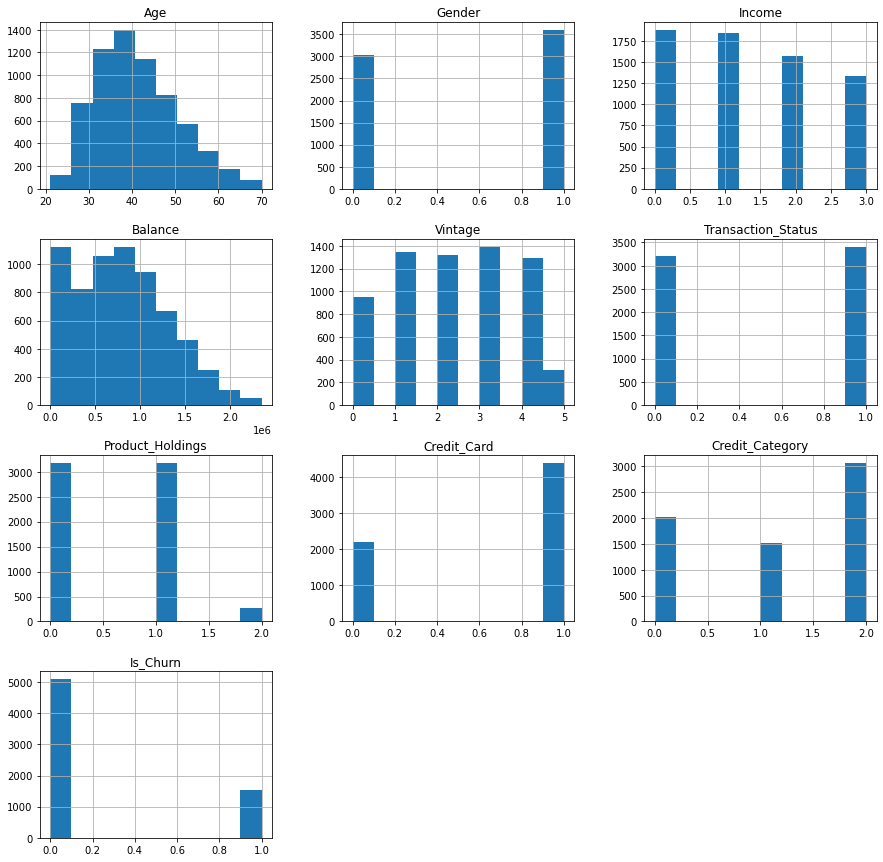

In [15]:
df.hist(figsize=(15,15))
plt.show()

In [16]:
df

,Age,Gender,Income,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category,Is_Churn
0,36,0,1.0,563266.44,4,0,0.0,0,0.0,1
1,53,0,2.0,875572.11,2,1,0.0,1,2.0,0
2,35,0,3.0,701607.06,2,1,1.0,0,2.0,0
3,43,0,3.0,1393922.16,0,1,1.0,1,2.0,1
4,39,0,3.0,893146.23,1,1,0.0,1,1.0,1
...,...,...,...,...,...,...,...,...,...,...
6645,61,1,1.0,1354526.19,4,1,1.0,1,2.0,1
6646,42,0,1.0,596286.54,3,1,1.0,1,0.0,0
6647,29,1,2.0,979298.19,2,0,1.0,0,2.0,0
6648,66,0,0.0,395233.65,3,0,1.0,1,2.0,1


In [17]:
X = df.drop('Is_Churn', axis=1)
Y = df['Is_Churn']

In [18]:
# adding samples to make all the categorical label values same

oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

In [19]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X.head()

,Age,Gender,Income,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category
0,-0.681214,-0.880116,-0.353713,-0.502993,1.357440,-0.820476,-1.010667,-1.197182,-1.438957
1,1.151198,-0.880116,0.613647,0.108098,-0.089019,1.218804,-1.010667,0.835295,1.016971
2,-0.789003,-0.880116,1.581007,-0.232301,-0.089019,1.218804,0.846597,-1.197182,1.016971
3,0.073309,-0.880116,1.581007,1.122357,-1.535479,1.218804,0.846597,0.835295,1.016971
4,-0.357847,-0.880116,1.581007,0.142485,-0.812249,1.218804,-1.010667,0.835295,-0.210993


In [20]:
maxAccu=0
maxRS=0

for i in range(1, 1000):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=i)
    lr=LogisticRegression()
    lr.fit(X_train, Y_train)
    pred = lr.predict(X_test)
    acc_score = (accuracy_score(Y_test, pred))*100
    
    if acc_score>maxAccu:
        maxAccu=acc_score
        maxRS=i

print("Best accuracy score is", maxAccu,"on Random State", maxRS)

Best accuracy score is 71.73144876325088 on Random State 307


In [21]:
# Classification Model Function

def classify(model, X, Y):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=maxRS)
    
    # Training the model
    model.fit(X_train, Y_train)
    
    # Predicting Y_test
    pred = model.predict(X_test)
    
    # Classification Report
    class_report = classification_report(Y_test, pred)
    print("\nClassification Report:\n", class_report)
    
    # Accuracy Score
    acc_score = (accuracy_score(Y_test, pred))*100
    print("Accuracy Score:", acc_score)
    
    # F1 Score
    f_one_score = (f1_score(Y_test, pred, average='macro'))*100
    print("F1 Score:", f_one_score)
    
    # Cross Validation Score
    cv_score = (cross_val_score(model, X, Y, cv=5).mean())*100
    print("Cross Validation Score:", cv_score)
    
    # Result of accuracy minus cv scores
    result = acc_score - cv_score
    print("\nAccuracy Score - Cross Validation Score is", result)

In [22]:
# Logistic Regression

model1=LogisticRegression()
classify(model1, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.72      0.71      1259
           1       0.72      0.72      0.72      1288

    accuracy                           0.72      2547
   macro avg       0.72      0.72      0.72      2547
weighted avg       0.72      0.72      0.72      2547

Accuracy Score: 71.73144876325088
F1 Score: 71.72952693853088
Cross Validation Score: 69.31762877444413

Accuracy Score - Cross Validation Score is 2.4138199888067504


In [23]:
# Support Vector Classifier

model2=SVC(C=1.0, kernel='rbf', gamma='auto', random_state=42)
classify(model2, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.77      0.75      1259
           1       0.76      0.71      0.74      1288

    accuracy                           0.74      2547
   macro avg       0.74      0.74      0.74      2547
weighted avg       0.74      0.74      0.74      2547

Accuracy Score: 74.04789948959561
F1 Score: 74.0386790554372
Cross Validation Score: 72.5669182922605

Accuracy Score - Cross Validation Score is 1.4809811973351117


In [24]:
# Decision Tree Classifier

model3=DecisionTreeClassifier(random_state=maxRS, max_depth=15)
classify(model3, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.78      0.77      1259
           1       0.78      0.74      0.76      1288

    accuracy                           0.76      2547
   macro avg       0.76      0.76      0.76      2547
weighted avg       0.76      0.76      0.76      2547

Accuracy Score: 76.16804083235179
F1 Score: 76.16327878588565
Cross Validation Score: 73.91190839922666

Accuracy Score - Cross Validation Score is 2.2561324331251313


In [25]:
# Random Forest Classifier

model4=RandomForestClassifier(max_depth=15, random_state=maxRS)
classify(model4, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.90      0.84      1259
           1       0.88      0.76      0.82      1288

    accuracy                           0.83      2547
   macro avg       0.83      0.83      0.83      2547
weighted avg       0.83      0.83      0.83      2547

Accuracy Score: 82.68551236749117
F1 Score: 82.61862557052541
Cross Validation Score: 80.46920970871074

Accuracy Score - Cross Validation Score is 2.2163026587804353


In [26]:
# K Neighbors Classifier

model5=KNeighborsClassifier(n_neighbors=15)
classify(model5, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.68      0.70      1259
           1       0.71      0.74      0.72      1288

    accuracy                           0.71      2547
   macro avg       0.72      0.71      0.71      2547
weighted avg       0.71      0.71      0.71      2547

Accuracy Score: 71.45661562622693
F1 Score: 71.4160080135931
Cross Validation Score: 70.41711651426048

Accuracy Score - Cross Validation Score is 1.0394991119664496


In [27]:
# Extra Trees Classifier

model6=ExtraTreesClassifier()
classify(model6, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.84      0.81      1259
           1       0.83      0.77      0.80      1288

    accuracy                           0.81      2547
   macro avg       0.81      0.81      0.81      2547
weighted avg       0.81      0.81      0.81      2547

Accuracy Score: 80.56537102473497
F1 Score: 80.54895195467014
Cross Validation Score: 78.7806781606039

Accuracy Score - Cross Validation Score is 1.784692864131074


In [28]:
# XGB Classifier

model7=xgb.XGBClassifier(verbosity=0)
classify(model7, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.92      0.85      1259
           1       0.91      0.75      0.82      1288

    accuracy                           0.84      2547
   macro avg       0.85      0.84      0.84      2547
weighted avg       0.85      0.84      0.84      2547

Accuracy Score: 83.70632116215155
F1 Score: 83.61514276072532
Cross Validation Score: 81.72584902560723

Accuracy Score - Cross Validation Score is 1.9804721365443214


In [29]:
# LGBM Classifier

model8=lgb.LGBMClassifier()
classify(model8, X, Y)


Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.95      0.85      1259
           1       0.93      0.74      0.82      1288

    accuracy                           0.84      2547
   macro avg       0.86      0.84      0.84      2547
weighted avg       0.86      0.84      0.84      2547

Accuracy Score: 84.13820180604633
F1 Score: 83.9972952158664
Cross Validation Score: 82.49161368461675

Accuracy Score - Cross Validation Score is 1.6465881214295734


In [32]:
# Choosing SVC Classifier

fmod_param = {'C' : [1.0, 2.0, 3.0, 4.0, 5.0],
              'kernel' : ['poly', 'rbf', 'sigmoid'],
              'random_state' : [21, 42, 111, 143, 808],
              'gamma' : ['scale', 'auto'],
              'decision_function_shape' : ['ovo', 'ovr']
             }

GSCV = GridSearchCV(SVC(), fmod_param, cv=5)
GSCV.fit(X_train,Y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1.0, 2.0, 3.0, 4.0, 5.0],
                         'decision_function_shape': ['ovo', 'ovr'],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['poly', 'rbf', 'sigmoid'],
                         'random_state': [21, 42, 111, 143, 808]})

In [33]:
GSCV.best_params_

{'C': 5.0,
 'decision_function_shape': 'ovo',
 'gamma': 'scale',
 'kernel': 'rbf',
 'random_state': 21}

In [34]:
Final_Model = SVC(C=5.0, decision_function_shape='ovo', gamma='scale', kernel='rbf', random_state=21)
Classifier = Final_Model.fit(X_train, Y_train)
fmod_pred = Final_Model.predict(X_test)
fmod_acc = (f1_score(Y_test, fmod_pred, average='macro'))*100
print("F1 score for the Best Model is:", fmod_acc)

F1 score for the Best Model is: 72.5417094332144


In [35]:
df = df_test.drop("ID", axis=1)
df

,Age,Gender,Income,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category
0,50,Female,More than 15L,1008636.39,2,1,2,1,Average
1,36,Male,5L - 10L,341460.72,2,0,2,1,Average
2,25,Female,10L - 15L,439460.10,0,0,2,1,Good
3,41,Male,Less than 5L,28581.93,0,1,2,1,Poor
4,48,Male,More than 15L,1104540.03,2,1,3+,0,Good
...,...,...,...,...,...,...,...,...,...
2846,40,Female,10L - 15L,1338458.22,0,0,1,1,Poor
2847,48,Female,More than 15L,1448280.27,0,1,2,1,Average
2848,59,Male,More than 15L,1100555.64,3,0,1,1,Poor
2849,34,Female,5L - 10L,1502818.92,2,0,1,1,Poor


In [36]:
# Label Encoder

le = LabelEncoder()
df["Gender"] = le.fit_transform(df["Gender"])

# Ordinal Encoder

oe = OrdinalEncoder()
oe_col = ["Income", "Product_Holdings", "Credit_Category"]

def ordinal_encode(df, column):
    df[column] = oe.fit_transform(df[column])
    return df

X=ordinal_encode(df, oe_col)

In [37]:
# Feature Scaling

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X.head()

,Age,Gender,Income,Balance,Vintage,Transaction_Status,Product_Holdings,Credit_Card,Credit_Category
0,0.909802,-1.087659,1.521174,0.378469,-0.148337,0.986413,0.708217,0.703575,-1.337061
1,-0.546246,0.919406,-0.297982,-0.892080,-0.148337,-1.013774,0.708217,0.703575,-1.337061
2,-1.690283,-1.087659,-1.207559,-0.705453,-1.490908,-1.013774,0.708217,0.703575,-0.165952
3,-0.026229,0.919406,0.611596,-1.487916,-1.490908,0.986413,0.708217,0.703575,1.005157
4,0.701795,0.919406,1.521174,0.561105,-0.148337,0.986413,2.402114,-1.421312,-0.165952


In [38]:
Predicted_Churn = Final_Model.predict(X)

# Checking the predicted churn details and storing in dataframe format
predicted_output = pd.DataFrame()
predicted_output['ID'] = df_test["ID"]
predicted_output['Is_Churn'] = Predicted_Churn
predicted_output

,ID,Is_Churn
0,55480787,0
1,9aededf2,0
2,a5034a09,0
3,b3256702,0
4,dc28adb5,0
...,...,...
2846,19e40adf,1
2847,52d5bc8d,0
2848,f708121b,1
2849,f008715d,1


In [39]:
predicted_output.to_csv("sample_submission_solutionfile.csv", index=False)